# Introduction to time series analysis and forecasting

The dataset consists of multipe time series representing an aggregated number of daily views for multiple Wikipedia articles, starting from July, 1st, 2015 up until August 2Oth, 2017.



### Run this first

In [2]:
import pandas as pd
from pandas.plotting import lag_plot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from main.utils.utils_methods import clean
import seaborn as sns
from hampel import hampel
from scipy import stats
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm

# diable statsmodels warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)

# Use parallel processing
import multiprocessing
from multiprocessing import Pool
print('CPU count:', multiprocessing.cpu_count())

# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(6, 3)})

# Import the 90 traffic time series
data = pd.read_csv("../compet_data/public/train.csv", index_col = "Day", parse_dates = True)

print(data.shape)
#print(data.head(3))
#print(data.info())

CPU count: 12
(782, 72)


<AxesSubplot:xlabel='Day'>

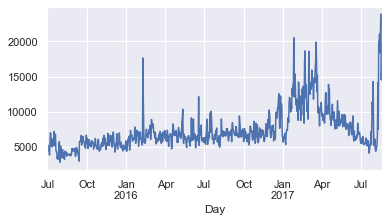

In [4]:
# Choose the time series to work with: "series-1", "series-2", ..., "series-90" 
# Reapeat the analysis for multiple series
myts = "series-19"
mycols = ["series-10", "series-19", "series-20", "series-21"]
DT = data[myts]
DT.plot()


### Add columns with year, month, and weekday name

In [ ]:
# Add columns with year, month, and weekday name
data['Year'] = data.index.year
data['Month'] = data.index.month
data['Weekday Name'] = data.index.day_name()
# display a random sampling of 5 rows
data.sample(5, random_state=0)

### Remove outliners ==> data_filtered

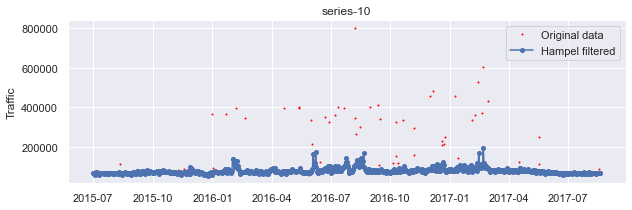

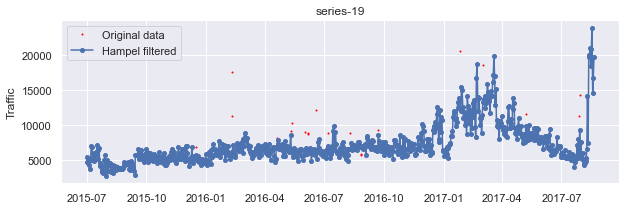

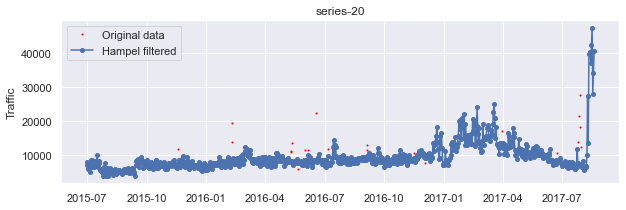

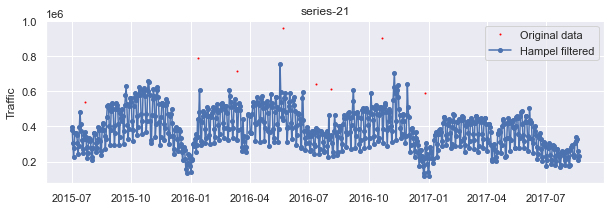

In [5]:
# remove outliners 
data_filtered = data.copy(deep=True)
for (colname, coldata) in data_filtered.iteritems():
    data_filtered[colname] = hampel(data_filtered[colname], window_size=8, n=3)

for s in mycols:
    fig, ax = plt.subplots(figsize=(10,3))
    ax.plot(data[s], label='Original data', marker='.', linestyle='None', markersize=2, color='red')
    ax.plot(data_filtered[s], label='Hampel filtered', marker='.', linestyle='-', markersize=8)
    ax.set_title(s)
    ax.set_ylabel('Traffic')
    ax.legend()

# Data Analysis

## Visualizing time series data

(https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/)

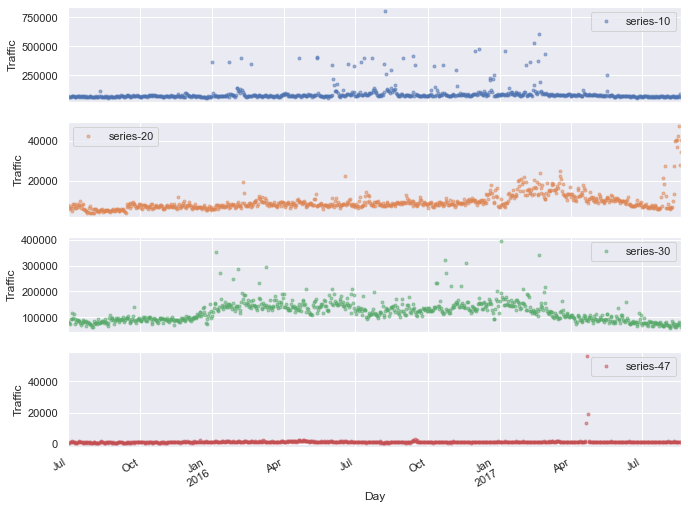

In [5]:
# With so many data points, the line plot is crowded and hard to read. 
# Let’s plot the data as dots instead
axes = data[mycols].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Traffic')


In [ ]:
# plot 1 year
data['series-10'].loc['2016'].plot(marker='.', alpha=0.5, linestyle='-')

In [ ]:
# plot 2 months
data['series-10'].loc['2016-01':'2016-02'].plot(marker='.', alpha=0.5, linestyle='-')

In [ ]:
# plot 1 month to see the weekly structure
data['series-10'].loc['2016-01-01':'2016-01-31'].plot(marker='.', alpha=0.5, linestyle='-')

### Customizing time series plots


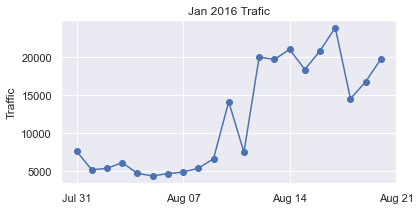

In [7]:
fig, ax, = plt.subplots()
ax.plot(data.loc['2017-07-31':'2017-08-20', myts], marker='o', linestyle='-')
ax.set_ylabel('Traffic')
ax.set_title('Jan 2016 Trafic')
# set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# format x-tick labels as 3 letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

## Periodic Structure and FFTs

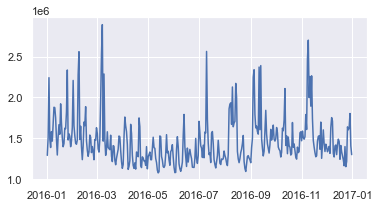

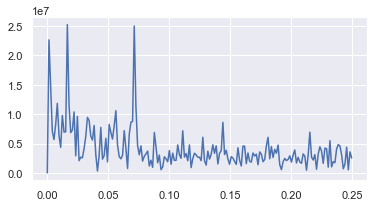

In [24]:
from scipy.fftpack import fft

#series = ["series-10", "series-20", "series-30", "series-40"]
series = ["series-10", "series-20"]

n=0
df = data.loc['2016-01-01':'2016-12 -31', series[n]].copy(deep=True) 
df = df.to_frame()
df["dy"] = df.index.dayofyear.to_numpy()
days = df["dy"].values
N = np.size(days)

plt.plot(df[series[n]])
plt.show()

df_fft = fft(df[series[n]].values)
df_fft[0] = 0
Fs = 1
# Avoid aliasing by multiplying sampling frequency by 1/2   
Fr = np.linspace(0, 0.5*Fs, N)
plt.plot(Fr[:N // 2], np.abs(df_fft)[:N // 2])   
plt.show()




## Seasonality

In [2]:
# check that the Day column is the index
data.index

DatetimeIndex(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04',
               '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08',
               '2015-07-09', '2015-07-10',
               ...
               '2017-08-11', '2017-08-12', '2017-08-13', '2017-08-14',
               '2017-08-15', '2017-08-16', '2017-08-17', '2017-08-18',
               '2017-08-19', '2017-08-20'],
              dtype='datetime64[ns]', name='Day', length=782, freq=None)

In [20]:
# let's copy the filtered data
_data = data_filtered.copy(deep=True)
_data.index

DatetimeIndex(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04',
               '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08',
               '2015-07-09', '2015-07-10',
               ...
               '2017-08-11', '2017-08-12', '2017-08-13', '2017-08-14',
               '2017-08-15', '2017-08-16', '2017-08-17', '2017-08-18',
               '2017-08-19', '2017-08-20'],
              dtype='datetime64[ns]', name='Day', length=782, freq=None)

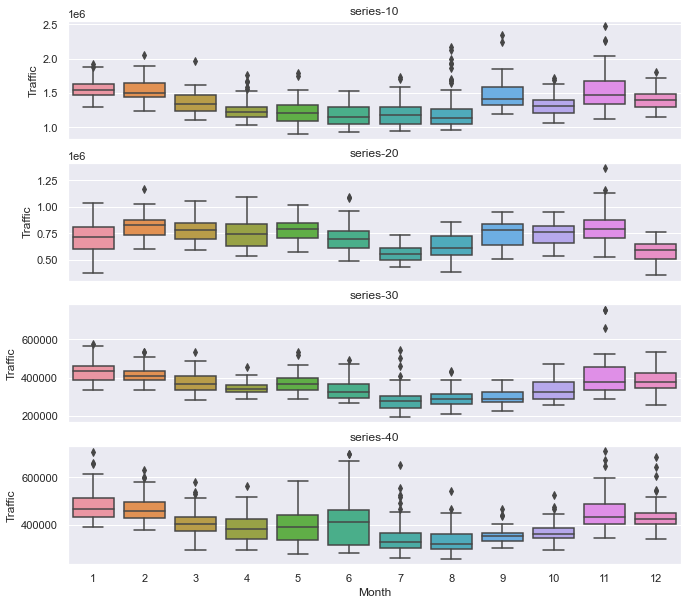

In [21]:
# first group the data by month, to visualize yearly seasonality.
fig, axes = plt.subplots(4, 1, figsize=(11,10), sharex=True)
for name, ax in zip(mycols, axes):
    sns.boxplot(data=_data, x='Month', y=name, ax=ax)
    ax.set_ylabel('Traffic')
    ax.set_title(name)
    # remove the automatic x-axis label from all but the bottom subplot
    if ax != axes[-1]:
        ax.set_xlabel('')


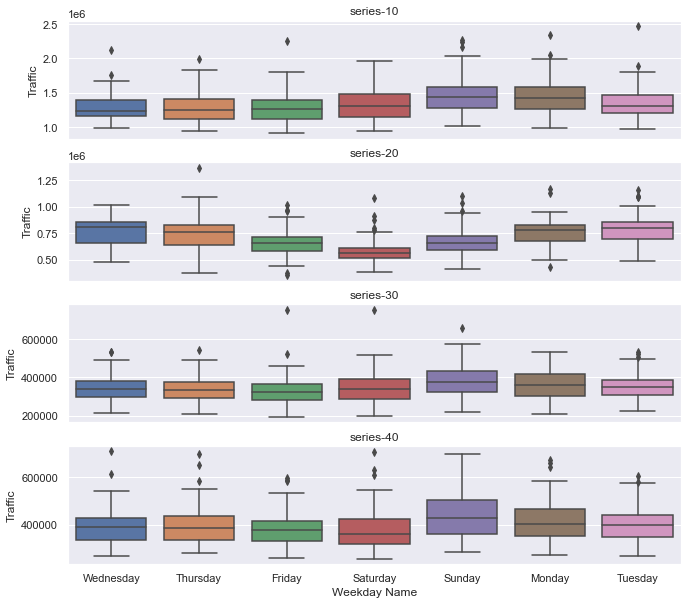

In [22]:
# Next, let’s group  time series by day of the week, to explore weekly seasonality.
fig, axes = plt.subplots(4, 1, figsize=(11,10), sharex=True)
for name, ax in zip(mycols, axes):
    sns.boxplot(data=_data, x='Weekday Name', y=name, ax=ax)
    ax.set_ylabel('Traffic')
    ax.set_title(name)
    # remove the automatic x-axis label from all but the bottom subplot
    if ax != axes[-1]:
        ax.set_xlabel('')

## Resampling (downsampling)

It is often useful to resample our time series data to a lower or higher frequency. Resampling to a lower frequency (downsampling) usually involves an aggregation operation — for example, computing monthly sales totals from daily data. The daily OPSD data we’re working with in this tutorial was downsampled from the original hourly time series. Resampling to a higher frequency (upsampling) is less common and often involves interpolation or other data filling method — for example, interpolating hourly weather data to 10 minute intervals for input to a scientific model.


We will focus here on downsampling, exploring how it can help us analyze our OPSD data on various time scales. We use the DataFrame’s resample() method, which splits the DatetimeIndex into time bins and groups the data by time bin. The resample() method returns a Resampler object, similar to a pandas GroupBy object. We can then apply an aggregation method such as mean(), median(), sum(), etc., to the data group for each time bin.

In [ ]:
# resample to weekly frequency, aggregating with mean
data_mean = data[mycols].resample('W').mean()
# By default, each row of the downsampled time series is labelled 
# with the right edge of the time bin.
data_mean.head(3)

In [ ]:
# By construction, our weekly time series has 1/7 as many data points as the daily time series
print(data.shape[0])
print(data_mean.shape[0])

In [ ]:
# Let’s plot the daily and weekly time series together over a single six-month period to compare them.
# Start and end of the date range to extract
start, end = '2017-01', '2017-06'
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(data.loc[start:end, 'series-10'],
marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(data_mean.loc[start:end, 'series-10'],
marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample')
ax.set_ylabel('Traffic')
ax.legend();

In [ ]:
# Compute the monthly sums, setting the value to NaN for any month which has
# fewer than 28 days of data
data_monthly = data[mycols].resample('M').sum(min_count=28)
data_monthly.head(3)

In [ ]:
fig, ax = plt.subplots(figsize=(11,6))
ax.plot(data_monthly['series-10'], color='orange', label='series-10', marker='o', linestyle='-')
ax.plot(data_monthly['series-20'], color='blue', label='series-20', marker='o', linestyle='-')
ax.plot(data_monthly['series-30'], color='red', label='series-30', marker='o', linestyle='-')
ax.plot(data_monthly['series-40'], color='yellow', label='series-40', marker='o', linestyle='-')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_ylabel('Traffic');

## Rolling windows

Rolling window operations are another important transformation for time series data. Similar to downsampling, rolling windows split the data into time windows and and the data in each window is aggregated with a function such as mean(), median(), sum(), etc. However, unlike downsampling, where the time bins do not overlap and the output is at a lower frequency than the input, rolling windows overlap and “roll” along at the same frequency as the data, so the transformed time series is at the same frequency as the original time series.


By default, all data points within a window are equally weighted in the aggregation, but this can be changed by specifying window types such as Gaussian, triangular, and others. We’ll stick with the standard equally weighted window here.

In [ ]:
# Let’s use the rolling() method to compute the 7-day rolling mean of our daily data. 
# We use the center=True argument to label each window at its midpoint.data_mean
data_7d = data[mycols].rolling(7, center=True).mean()
data_7d.head(10)
# We can see that the first non-missing rolling mean value is on 2015-07-04, 
# because this is the midpoint of the first rolling window.

In [ ]:
# visualize the differences between rolling mean and resampling
start, end = '2017-01', '2017-06'
# Plot daily, weekly resampled, and 7-day rolling mean time series together
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(data.loc[start:end, 'series-10'], label='Daily', marker='.', linestyle='-', linewidth=0.5)
ax.plot(data_mean.loc[start:end, 'series-10'], label='Weekly Mean Resample', marker='o', linestyle='-', markersize=8)
ax.plot(data_7d.loc[start:end, 'series-10'], label='7-day Rolling mean', marker='.', linestyle='-', markersize=8)
ax.set_ylabel('Traffic')
ax.legend()

# We can see that data points in the rolling mean time series have the same spacing as the daily data, 
# but the curve is smoother because higher frequency variability has been averaged out. In the 
# rolling mean time series, the peaks and troughs tend to align closely with the peaks and 
# troughs of the daily time series. In contrast, the peaks and troughs in the weekly resampled 
# time series are less closely aligned with the daily time series, since the resampled time 
# series is at a coarser granularity.



In [ ]:
# We’ve already computed 7-day rolling means, so now let’s compute the 365-day rolling mean of our data.
# The min_periods=360 argument accounts for a few isolated missing days in the time series
data_365d = data[mycols].rolling(window=365, center=True, min_periods=360).mean()


In [ ]:
# Plot daily, 7-day rolling mean, and 365-day rolling mean time series
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(data['series-10'], label='Daily', marker='.', linestyle='None', markersize=2, color='0.6')
ax.plot(data_7d['series-10'], label='7-day Rolling mean', marker='.', linestyle='-', markersize=8)
ax.plot(data_365d['series-10'], label='Trend (365-day Rolling mean)', color='0.2', linewidth=3)
ax.set_ylabel('Traffic')
ax.legend()

## Clean up your time series data with a Hampel filter

(https://medium.com/wwblog/clean-up-your-time-series-data-with-a-hampel-filter-58b0bb3ebb04)

(https://medium.com/@neuraljojo/day-19-the-easiest-way-to-remove-outliers-from-time-series-data-d7a3f322d759)

A Hampel filter is a filter we can apply to our time series to identify outliers and replace them with more representative values. The filter is basically a configurable-width sliding window that we slide across the time series. For each window, the filter calculates the median and estimates the window’s standard deviation 𝜎 using the median absolute deviation: 𝜎≈1.4826 MAD.

For any point in the window, if it is more than 3𝜎 out from the window’s median, then the Hampel filter identifies the point as an outlier and replaces it with the window’s median.

installation: pip install hampel

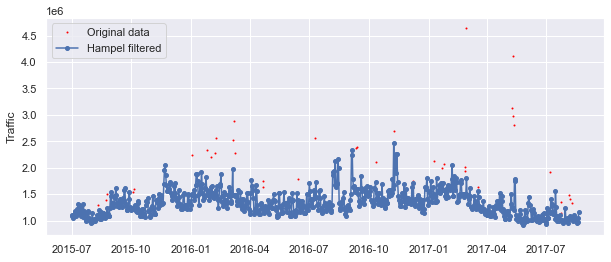

In [7]:
# default window_size is 5, default standard deviation is 3
#data_filtered = hampel(data['series-10'])
data_filtered = hampel(data['series-10'], window_size=8, n=3)

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(data['series-10'], label='Original data', marker='.', linestyle='None', markersize=2, color='red')
ax.plot(data_filtered, label='Hampel filtered', marker='.', linestyle='-', markersize=8)

ax.set_ylabel('Traffic')
ax.legend()


## Analyze the method cleanup

In [ ]:
from supersmoother import SuperSmoother, LinearSmoother
# https://www.statsmodels.org/stable/index.html
# https://www.statsmodels.org/devel/generated/statsmodels.tsa.seasonal.STL.html
from statsmodels.tsa.seasonal import STL

learn = DT
n_learn = len(learn)
if n_learn % 2 == 0:
    n_learn = n_learn - 1
# Season-Trend decomposition using LOESS.
# Estimate season, trend and residuals components.
# https://www.statsmodels.org/devel/generated/statsmodels.tsa.seasonal.STL.html
stl = STL(
    learn, # Data to be decomposed.
    period=7, # Periodicity of the sequence
    robust=True, # Flag indicating whether to use a weighted version that is robust to some forms of outliers.
    seasonal=n_learn # Length of the seasonal smoother
    )
res = stl.fit()
res.plot()

In [ ]:
series = DT
detrend = series - res.trend
strength = 1 - np.var(res.resid) / np.var(detrend)
if strength >= 0.6:
    series = res.trend + res.resid  # deseasonlized series
print(strength)
series.plot()

In [ ]:
# Return evenly spaced values within a given interval.
# For integer arguments the function is equivalent to the Python built-in 
# range function, but returns an ndarray rather than a list.
tt = np.arange(len(series))

# SuperSmoother is a non-parametric locally-linear smooth in which the size of the 
# local neighborhood is tuned to the characteristics of the data
# https://github.com/jakevdp/supersmoother/blob/master/examples/Supersmoother.ipynb
model = SuperSmoother()
# t: time locations of the points to smooth
# y: y locations of the points to smooth
model.fit(t=tt, y=series)
# find the smoothed fit to the data
yfit = model.predict(tt)
# calculates the difference between the actual series and the smoothed fit
resid = series - yfit


In [ ]:
DT.plot()
resid.plot()

In [ ]:
resid_q = np.quantile(a=resid, q=[0.25, 0.75])
iqr = np.diff(resid_q)
#limits = resid.q + 3 * iqr * [-1, 1]
limits = resid_q + 5 * iqr * [-1, 1]
print(resid_q)
print(iqr)
print(limits)

## Let's go back to the original code...

In [ ]:
    series = DT
    series_cleaned_1, outliers_1 = clean(series)
    series_cleaned_2, outliers_2 = clean(series_cleaned_1)

    plt.subplot(3, 1, 1)
    plt.plot(series)
    plt.plot(series.loc[outliers_1], 'ro')

    plt.subplot(3, 1, 2)
    plt.plot(series_cleaned_1)
    plt.plot(series_cleaned_1.loc[outliers_2], 'ro')

    plt.subplot(3, 1, 3)
    plt.plot(series_cleaned_2)

In [ ]:
# Handle outliers
DT_cleaned_1, _ = clean(DT)
DT_cleaned_2, _ = clean(DT_cleaned_1)
DT.loc[:] = DT_cleaned_2
DT.plot()


## Seasonal plots

The following code shows how to compute a seasonal plot (for the day of the month).

In [42]:
# add columns with day, month, year,...
DT = DT.to_frame()
DT["d"] = data.index.day.to_numpy()
DT["m"] = data.index.month.to_numpy()
DT["y"] = data.index.year.to_numpy()
DT["w"] = data.index.weekday.to_numpy()
DT["wy"] = data.index.weekofyear.to_numpy()
DT.tail()

series-40   d  m     y  w  wy
Day                                      
2017-08-16     306174  16  8  2017  2  33
2017-08-17     308663  17  8  2017  3  33
2017-08-18     310423  18  8  2017  4  33
2017-08-19     277816  19  8  2017  5  33
2017-08-20     307630  20  8  2017  6  33

In [43]:
# show the daily data grouped by Month and then Year. 
DT[[myts, "d", "m", "y"]].pivot_table(index=['d'], columns=['m', 'y']).head(10)

series-40                                                              \
m         1                   2                   3                   4    
y       2016      2017      2016      2017      2016      2017      2016   
d                                                                          
1   497588.0  659141.0  520099.0  406554.0  514501.0  405831.0  368746.0   
2   611466.0  503954.0  452154.0  749780.0  467566.0  358392.0  352837.0   
3   727613.0  466456.0  460889.0  375956.0  463497.0  340105.0  429494.0   
4   662242.0  612791.0  501353.0  427843.0  404793.0  347048.0  473535.0   
5   513660.0  487002.0  472770.0  682664.0  401384.0  428441.0  433120.0   
6   513075.0  535142.0  442984.0  659659.0  537787.0  383889.0  402458.0   
7   459279.0  662252.0  596402.0  447966.0  441085.0  376477.0  405518.0   
8   527494.0  602045.0  646720.0  383958.0  408222.0  394912.0  413835.0   
9   431585.0  483814.0  582410.0  400249.0  401787.0  394617.0  338494.0   
10  596289.0  421583.0  520428.0  411500.0  400434.0  425126.0  484915.0   

                                  ...                                          \
m                   5             ...        8                   9              
y       2017      2016      2017  ...      2016      2017      2015      2016   
d                                 ...                                           
1   293639.0  424424.0  464016.0  ...  321668.0  267107.0  321020.0  307941.0   
2   330758.0  356611.0  683565.0  ...  316110.0  267903.0  321403.0  310445.0   
3   331527.0  446452.0  344141.0  ...  316458.0  295841.0  310427.0  302432.0   
4   344211.0  385431.0  353164.0  ...  359054.0  276234.0  312860.0  397080.0   
5   314351.0  403009.0  334431.0  ...  373922.0  298254.0  310740.0  361271.0   
6   305533.0  376842.0  328551.0  ...  316802.0  295911.0  387035.0  345458.0   
7   335501.0  398495.0  417785.0  ...  351702.0  283434.0  355091.0  357754.0   
8   440150.0  418255.0  397056.0  ...  335562.0  296098.0  331152.0  313302.0   
9   327168.0  493262.0  369788.0  ...  386813.0  276931.0  324206.0  326295.0   
10  334357.0  472674.0  355618.0  ...  357105.0  289595.0  340788.0  477249.0   

                                                                 
m         10                  11                  12             
y       2015      2016      2015      2016      2015       2016  
d                                                                
1   320681.0  329578.0  357927.0  423321.0  395878.0   387542.0  
2   438825.0  520454.0  345030.0  992323.0  422684.0   427447.0  
3   396737.0  464555.0  342128.0  478058.0  421425.0   393619.0  
4   474049.0  443340.0  421249.0  430016.0  388398.0   496490.0  
5   352554.0  400861.0  385649.0  406624.0  339272.0   439171.0  
6   332475.0  379478.0  348578.0  516571.0  420652.0   401417.0  
7   365556.0  348259.0  389952.0  491148.0  402300.0   437996.0  
8   352426.0  333896.0  511683.0  574313.0  403559.0  1345121.0  
9   330730.0  401543.0  401927.0  710400.0  427170.0  1159401.0  
10  318445.0  370168.0  364760.0  552570.0  432198.0   494112.0  

[10 rows x 26 columns]

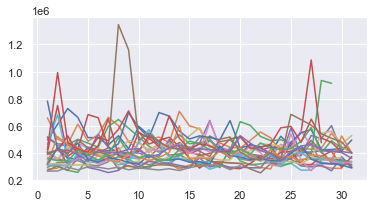

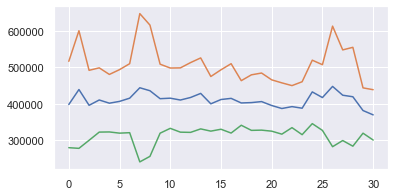

In [44]:
## Day of the month
patterns_day_month = DT[[myts, "d", "m", "y"]].pivot_table(index=['d'], columns=['m', 'y'])
plt.plot(patterns_day_month)
plt.show()

# Average seasonal pattern
avg_day_month = np.nanmean(patterns_day_month, axis = 1) # calculate the mean of array ignoring the NaN value
std_day_month = np.nanstd(patterns_day_month, axis = 1) # Compute the standard deviation along the specified axis, while ignoring NaNs
plt.plot(pd.DataFrame({"avg": avg_day_month, "std+": avg_day_month +  std_day_month, "std-": avg_day_month -  std_day_month}))
plt.show()


Using the previous code, produce a seasonal plot for the day of the week.

In [45]:
# show the daily data grouped by Month and then Year. 
DT[[myts, "w", "m", "y"]].pivot_table(index=['w'], columns=['m', 'y'])

series-40                                                         \
m         1                     2                     3               
y       2016       2017       2016       2017       2016       2017   
w                                                                     
0  518861.25  504866.20  614306.00  671981.75  438155.50  396809.50   
1  443393.25  428399.60  500198.50  459241.50  463325.80  380575.00   
2  436546.75  505037.00  493227.00  405863.00  421380.00  389055.00   
3  444517.00  470208.50  459886.75  493660.50  453594.20  378892.20   
4  455105.00  468973.75  431360.75  405022.00  448946.50  385089.20   
5  456143.60  574864.50  481206.00  460176.25  381044.75  388779.25   
6  567595.60  592772.80  667581.50  557052.25  500474.00  450857.25   

                                               ...                            \
m         4                     5              ...         8                   
y       2016       2017       2016       2017  ...       2016           2017   
w                                              ...                             
0  439391.00  383846.00  472700.00  371655.60  ...  359757.00  277447.000000   
1  470117.25  361404.50  469869.20  416740.60  ...  356968.00  285254.000000   
2  429862.00  358502.50  412119.00  320257.20  ...  343201.00  283669.333333   
3  401549.75  362961.00  410185.25  343197.00  ...  432973.50  298033.000000   
4  373465.20  345286.75  386965.25  339836.75  ...  380229.50  289926.666667   
5  356522.00  367999.20  454712.25  321733.75  ...  351269.50  283800.666667   
6  502479.75  388857.20  480074.60  383951.50  ...  408328.25  296047.333333   

                                                                     \
m         9                     10                    11              
y       2015       2016       2015       2016       2015       2016   
w                                                                     
0  356718.75  408652.75  382331.25  392467.40  416992.80  486558.00   
1  345589.40  363946.00  351542.00  393780.25  388744.75  468459.20   
2  346004.60  361728.50  349353.00  368103.75  413153.00  608165.80   
3  337256.25  332995.40  337736.40  403363.00  403663.75  517689.75   
4  358654.25  336937.80  352259.00  428103.00  427858.50  486844.00   
5  326962.50  354694.50  333075.00  341066.00  403073.00  436525.75   
6  391323.25  451168.75  427259.00  447062.40  464675.20  590661.25   

                         
m         12             
y       2015       2016  
w                        
0  440172.00  521170.75  
1  410119.40  464241.75  
2  415883.20  442306.50  
3  395825.80  607121.60  
4  396646.25  577256.00  
5  400466.00  403017.60  
6  463175.50  557884.50  

[7 rows x 26 columns]

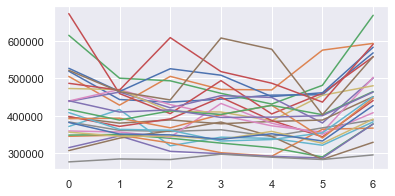

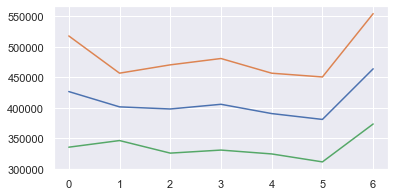

In [46]:
## Day of the week
patterns_day_week = DT[[myts, "w", "m", "y"]].pivot_table(index=['w'], columns=['m', 'y'])
plt.plot(patterns_day_week)
plt.show()

# Average seasonal pattern
avg_day_week = np.nanmean(patterns_day_week, axis = 1) # calculate the mean of array ignoring the NaN value
std_day_week = np.nanstd(patterns_day_week, axis = 1) # Compute the standard deviation along the specified axis, while ignoring NaNs
plt.plot(pd.DataFrame({"avg": avg_day_week, "std+": avg_day_week +  std_day_week, "std-": avg_day_week -  std_day_week}))
plt.show()

## Lag plots
Produce lagged scatterplots for multiple lags. What do you observe? Add the diagonal for a better visualization.

In [24]:
# Use pd.shift
# help us establish temporal precedence in our data in order to derive insights.
# See https://timeseriesreasoning.com/2019/10/01/auto-correlation-scatter-plots/
from pandas import DataFrame
from pandas import concat

def draw_diagonale(g):
    x0, x1 = g.get_xlim()
    y0, y1 = g.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.plot(lims, lims, ':k') 

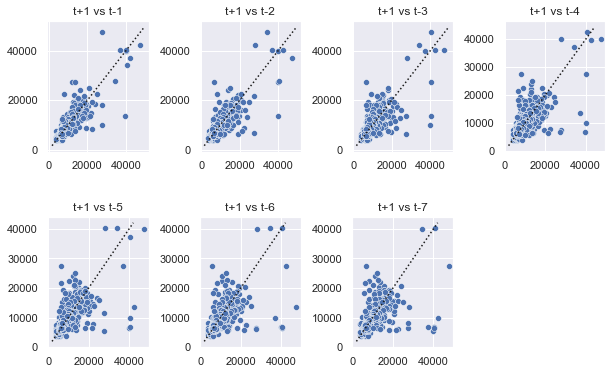

In [25]:
 # lag 1..7 days

values = DataFrame(DT.values)
lags = 7
columns = [values]
for i in range(1,(lags + 1)):
	columns.append(values.shift(i))
dataframe = concat(columns, axis=1)
columns = ['t+1']
for i in range(1,(lags + 1)):
	columns.append('t-' + str(i))
dataframe.columns = columns

fig = plt.figure(figsize=(10,6))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for i in range(1,(lags + 1)):
    ax = fig.add_subplot(240 + i)
    ax.set_title('t+1 vs t-' + str(i))
    s = sns.scatterplot(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values)
    draw_diagonale(s)


In [ ]:
 # lag 1..12 months

values = DataFrame(DT.values)
lags = 7
columns = [values]
for i in range(1,(lags + 1)):
	columns.append(values.shift(i*30))
dataframe = concat(columns, axis=1)
columns = ['t+1']
for i in range(1,(lags + 1)):
	columns.append('t-' + str(i))
dataframe.columns = columns

fig = plt.figure(figsize=(10,6))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for i in range(1,(lags + 1)):
    ax = fig.add_subplot(240 + i)
    ax.set_title('t+1 vs t-' + str(i))
    s = sns.scatterplot(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values)
    draw_diagonale(s)


## Autocorrelation
Plot the autocorrelation function (ACF) for the first 20 lags, and interpret the results. 
Recompute the ACF after applying a seasonal difference. 




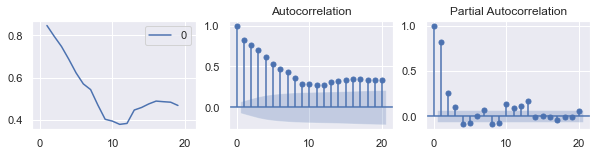

In [25]:
# computes the Pearson correlation between the Series and its shifted self.
# The Pearson correlation coefficient has a value between -1 and 1, 
# where 0 is no linear correlation, >0 is a positive correlation, 
# and <0 is a negative correlation. Positive correlation is when two variables 
# change in tandem while a negative correlation coefficient means that 
# the variables change inversely. 
pcc = np.array([])
for i in range(1, 20+1):
    pcc = np.append(pcc, DT.autocorr(lag=i))
df = pd.DataFrame(data=pcc).shift(1)
#print(df)
fig, axes = plt.subplots(ncols=3, nrows=1, sharex=True, figsize=(10,2))
df.plot(ax=axes[0])
sm.graphics.tsa.plot_acf(DT.values, lags=20, ax=axes[1])
sm.graphics.tsa.plot_pacf(DT.values, lags=20, ax=axes[2])
plt.show()

# => small weekly correlation

In order to take a look at the trend of time series data, we first need to remove the seasonality. Lagged differencing is a simple transformation method that can be used to remove the seasonal component of the series. A lagged difference is defined by:

difference(t) = observation(t) — observation(t-interval)

where interval is the period.

In [ ]:
# creates a differenced dataset. The function would loop through a provided series
# and calculate the differenced values at the specified interval or lag.
def difference(dataset, interval):
    diff = list()
    # begin the differenced dataset after the specified interval to ensure differenced values can, in fact, be calculated
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff


traffic_diff = difference(DT.values, 7)
plt.plot(traffic_diff)
plt.show()


In [ ]:
plot_acf(traffic_diff['traffic_diff'], lags=20)
plt.show()

## White noise process



- Generate a time series with 500 observations from a white noise process with zero mean and unit standard deviation.
- Plot the tiime series
- Compute and plot the ACF for 50 lags
- Did you expect to see such results? Why?

A time series is white noise if the variables are independent and identically distributed with a mean of zero. This means that all variables have the same variance (sigma^2) and each value has a zero correlation with all other values in the series. If the variables in the series are drawn from a Gaussian distribution, the series is called Gaussian white noise.

White noise is an important concept in time series analysis and forecasting. It is important for two main reasons:

- Predictability: If your time series is white noise, then, by definition, it is random. You cannot reasonably model it and make predictions.
- Model Diagnostics: The series of errors from a time series forecast model should ideally be white noise.

Time series data are expected to contain some white noise component on top of the signal generated by the underlying process. For example:

y(t) = signal(t) + noise(t)

Once predictions have been made by a time series forecast model, they can be collected and analyzed. The series of forecast errors should ideally be white noise.

When forecast errors are white noise, it means that all of the signal information in the time series has been harnessed by the model in order to make predictions. All that is left is the random fluctuations that cannot be modeled.

A sign that model predictions are not white noise is an indication that further improvements to the forecast model may be possible.

(https://machinelearningmastery.com/white-noise-time-series-python)


In [ ]:
# use np.random.normal and plot_acf
from random import seed
from pandas.plotting import autocorrelation_plot
# seed random number generator
seed(1)
# create white noise series
mu, sigma = 0, 1.0 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
# convert to a pandas series
series = pd.Series(s)

# summary stats
print(series.describe())

count, bins, ignored = plt.hist(s, 30)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.show()

series.plot()
plt.show()


In [ ]:
# create a correlogram and check for any autocorrelation with lag variables.
autocorrelation_plot(series)
plt.show()

# The correlogram does not show any obvious autocorrelation pattern. 
# There are some spikes above the 95% and 99% confidence level, but these are a statistical fluke.

Summary

- White noise time series is defined by a zero mean, constant variance, and zero correlation.
- If your time series is white noise, it cannot be predicted, and if your forecast residuals are not white noise, you may be able to improve your model.
- The statistics and diagnostic plots you can use on your time series to check if it is white noise.

## Stationarity



The observations in a stationary time series are not dependent on time.

Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations.

When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary to be effective

(https://machinelearningmastery.com/time-series-data-stationary-python/)

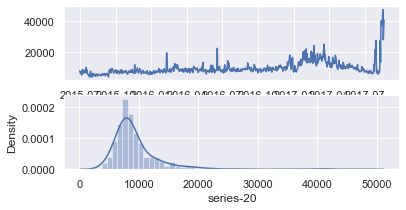

In [17]:
# Let's recap with our DT series
plt.figure(1)
# line plot
plt.subplot(211)
plt.plot(DT)
# histogram
plt.subplot(212)
sns.distplot(DT)
plt.show()

# Because we are looking at the mean and variance, we are assuming that the data conforms to a Gaussian distribution.

In [18]:
# Stationarity test using summary satitistics:
# Split the time series into two (or more) partitions and compare the mean and variance of each group. 
# If they differ and the difference is statistically significant, the time series is likely non-stationary.
X = DT.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f ratio:%f' % (mean1, mean2, mean1/mean2))
print('variance1=%f, variance2=%f ratio:%f' % (var1, var2, var1/var2))

# Running this example shows that the mean and variance values are different, but in the same ball-park.
# So, the series is probably stationary
# !! if the data distribution is not gaussian, the mean and variance tests are less meaningful

mean1=7603.112532, mean2=11500.767263 ratio:0.661096
variance1=3711507.475828, variance2=31945744.270642 ratio:0.116182


In [5]:
def adf_test(df):
	# Augmented Dickey-Fuller test
	result = adfuller(df.values)
	print('ADF Statistic: %f' % result[0])
	print('p-value: %f' % result[1])
	print('Critical Values:')
	for key, value in result[4].items():
		print('\t%s: %.3f' % (key, value))

adf_test(DT)

# The more negative the ADF statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).
#
# If p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# If p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
#
# As part of the output, we get a look-up table to help determine the ADF statistic. We can see that our 
# statistic value of -2.85 is less than the value of -2.865 at 5%. This suggests that we can reject the 
# null hypothesis with a significance level of less than 5% (i.e. a low probability that the result is a statistical fluke).
# 
# Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series 
# is stationary or does not have time-dependent structure.

ADF Statistic: 0.095514
p-value: 0.965753
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [18]:
# make the series stationary by differencing; the number of times the differencing was performed to make the series stationary is the d value.
adf_test(DT)

d = 1
ts_diff = DT.diff(periods=d).dropna()
adf_test(ts_diff)
print(ts_diff.head())


ADF Statistic: 0.095514
p-value: 0.965753
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
ADF Statistic: -12.450530
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
Day
2015-07-02    -955.0
2015-07-03    -962.0
2015-07-04     545.0
2015-07-05     900.0
2015-07-06   -2319.0
Name: series-20, dtype: float64


## Transformations



(https://machinelearningmastery.com/power-transform-time-series-forecast-data-python/)

### No transform

In [ ]:
series = DT.values

# make a probability plot for it, to show it is non-normal in the tails:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(211)
prob = stats.probplot(series, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

# histogram
ax1 = fig.add_subplot(212)
sns.distplot(series)


### Square Root Transform



A time series that has a quadratic growth trend can be made linear by taking the square root.


In [ ]:
from numpy import sqrt
series = DT.values
# sqrt transform
transform = sqrt(series)

plt.figure(figsize=(6,7))
plt.subplots_adjust(hspace=0.4)
plt.figure(1)
# line plot
plt.subplot(311)
plt.plot(transform)
# probplot
ax1 = plt.subplot(312)
prob = stats.probplot(transform, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
# histogram
plt.subplot(313)
sns.distplot(transform)
plt.show()

# of course, the data do not have a quadratic growth trend

### Log Transform



A class of more extreme trends are exponential, often graphed as a hockey stick.

Time series with an exponential distribution can be made linear by taking the logarithm of the values. This is called a log transform.



In [ ]:
from numpy import log
series = DT.values
transform = log(series)

plt.figure(figsize=(6,7))
plt.subplots_adjust(hspace=0.4)
plt.figure(1)
# line plot
plt.subplot(311)
plt.plot(transform)
# probplot
ax1 = plt.subplot(312)
prob = stats.probplot(transform, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
# histogram
plt.subplot(313)
sns.distplot(transform)
plt.show()

# of course, the data do not have an exponential growth trend


### Box-Cox Transform



The Box-Cox transformation transforms our data so that it closely resembles a normal distribution.

The square root transform and log transform belong to a class of transforms called power transforms.

The Box-Cox transform is a configurable data transform method that supports both square root and log transform, as well as a suite of related transforms.

More than that, it can be configured to evaluate a suite of transforms automatically and select a best fit. It can be thought of as a power tool to iron out power-based change in your time series. The resulting series may be more linear and the resulting distribution more Gaussian or Uniform, depending on the underlying process that generated it.

The scipy.stats library provides an implementation of the Box-Cox transform. The boxcox() function takes an argument, called lambda, that controls the type of transform to perform.

Below are some common values for lambda

lambda = -1. is a reciprocal transform (x will replace by the inverse of x (1/x)).

lambda = -0.5 is a reciprocal square root transform.

lambda = 0.0 is a log transform.

lambda = 0.5 is a square root transform.

lambda = 1.0 is no transform.


In [ ]:
from scipy.stats import boxcox

# scipy.stats.boxcox(x, lmbda=None, alpha=None)
#  If lmbda is None, find the lambda that maximizes the log-likelihood function and return it as the second output argument.
series = DT.values
transform, lam = boxcox(series)
print('Lambda: %f' % lam)

plt.figure(figsize=(6,7))
plt.subplots_adjust(hspace=0.4)
plt.figure(1)
# line plot
plt.subplot(311)
plt.plot(transform)
# probplot
ax1 = plt.subplot(312)
prob = stats.probplot(transform, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
# histogram
plt.subplot(313)
sns.distplot(transform)
plt.show()

# the normality at the tails is improved:

In [ ]:
# Let's review the stationarity criteria on the transformed data
X = transform
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f ratio:%f' % (mean1, mean2, mean1/mean2))
print('variance1=%f, variance2=%f ratio:%f' % (var1, var2, var1/var2))

result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

# I am noit sure what we can conclude...

## Time series decomposition 


Decompose the time series into trend, seasonal and remainder components. Does it help you to understand the data?

A useful abstraction for selecting forecasting methods is to break a time series down into systematic and unsystematic components.

- **Systematic**: Components of the time series that have consistency or recurrence and can be described and modeled.
- **Non-Systematic**: Components of the time series that cannot be directly modeled.
A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

- **Level**: The average value in the series.
- **Trend**: The increasing or decreasing value in the series.
- **Seasonality**: The repeating short-term cycle in the series.
- **Noise**: The random variation in the series.

A series is thought to be an aggregate or combination of these four components. All series have a level and noise. The trend and seasonality components are optional.

It is helpful to think of the components as combining either additively or multiplicatively.

An **additive model** suggests that the components are added together as follows:

y(t) = Level + Trend + Seasonality + Noise

- An additive model is linear where changes over time are consistently made by the same amount.
- A linear trend is a straight line.
- A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles).

A **multiplicative model** suggests that the components are multiplied together as follows:

y(t) = Level * Trend * Seasonality * Noise

- A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time.
- A nonlinear trend is a curved line.
- A non-linear seasonality has an increasing or decreasing frequency and/or amplitude over time.

(https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)

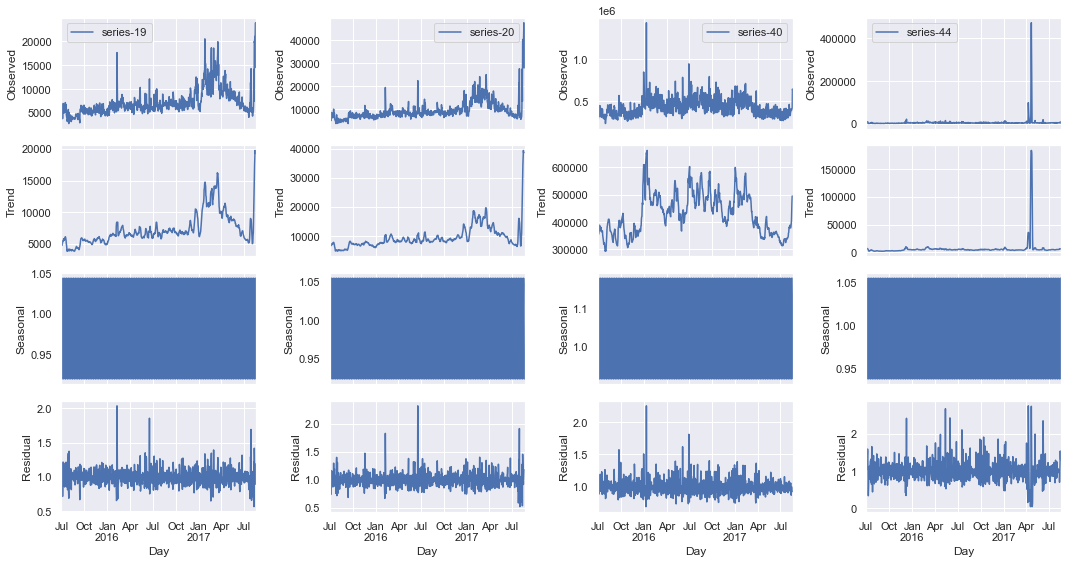

In [8]:
# The statsmodels library provides an implementation of the naive, or classical, 
# decomposition method in a function called seasonal_decompose(). 
# It requires that you specify whether the model is additive or multiplicative.
from statsmodels.tsa.seasonal import seasonal_decompose

series = ["series-19", "series-20", "series-40", "series-44"]

def plotseasonal(res, axes):
    res.observed.plot(ax=axes[0], legend=True)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

# additive decomposition
#model='additive'
model='multiplicative'

fig, axes = plt.subplots(ncols=len(series), nrows=4, sharex=True, figsize=(15,8))

n = 0
results = []
for s in range(len(series)):
    res = seasonal_decompose(data[series[n]], model=model)
    plotseasonal(res, axes[:,n])
    results.append(res)
    n += 1

plt.tight_layout()
plt.show()


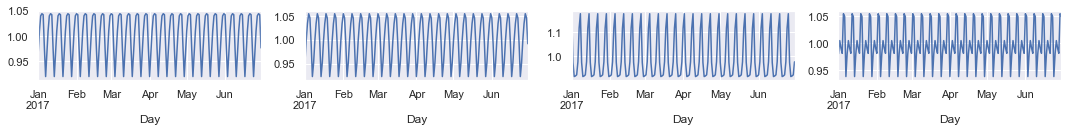

In [9]:
# let's look into the details of a seasonal plot
period = "'2017-01-01':'2017-06-30'"
fig, axes = plt.subplots(ncols=len(series), nrows=1, sharex=True, figsize=(15,2))

n = 0
for res in results:
    res.seasonal.loc['2017-01-01':'2017-06-30'].plot(ax=axes[n], legend=False)
    n += 1
plt.tight_layout()
plt.show()


In [ ]:
# STL decomposition
# STL stands for Seasonal and Trend decomposition using Loess
# https://www.statsmodels.org/stable/index.html
# https://www.statsmodels.org/stable/examples/notebooks/generated/stl_decomposition.html
from statsmodels.tsa.seasonal import STL

fig, axes = plt.subplots(ncols=len(series), nrows=4, sharex=True, figsize=(15,8))

n = 0
results_stl = []
for s in range(len(series)):
    learn = data[series[n]]
    n_learn = len(learn)
    if n_learn % 2 == 0:
        n_learn = n_learn - 1
    res_stl = STL(
        learn, # Data to be decomposed.
        period=7, # Periodicity of the sequence
        robust=True, # Flag indicating whether to use a weighted version that is robust to some forms of outliers.
        seasonal=n_learn # Length of the seasonal smoother. Must be odd.
        ).fit()
    plotseasonal(res, axes[:,n])
    results_stl.append(res_stl)
    n += 1


In [ ]:
# let's look into the details of the seasonal plots
period = "'2017-01-01':'2017-06-30'"
fig, axes = plt.subplots(ncols=len(series), nrows=1, sharex=True, figsize=(15,2))

n = 0
for res in results_stl:
    res.seasonal.loc['2017-01-01':'2017-06-30'].plot(ax=axes[n], legend=False)
    n += 1
plt.tight_layout()
plt.show()

# Forecasting



Produce forecasts for the next 21 days using simple methods. Analyze the residuals. Compare the forecast accuracy for different accuracy measures.

(https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/)

To run a forecast:

1. Run the first block at the top of this notebook 
2. Run the Prepare block just below
3. Run the forecast

### Prepare

In [24]:
from numpy.core.fromnumeric import mean
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from random import random

smapes = np.array([])

def initialize_training():
    global smapes
    smapes = np.array([])

def prepare_data(remove_outliners=False, mode='validation'):

    # subsetting train and test data 
    if (mode == 'validation'):
        # take 20 days for testing
        df_train = data.loc['2015-07-01':'2017-07-30'].copy(deep=True)
        df_test = data.loc['2017-07-31':'2017-08-20'].copy(deep=True)
    elif (mode == 'kaggle'):
        # use full series to model and predict
        df_train = data.loc['2015-07-01':'2017-09-10'].copy(deep=True)
        # overlap the forecast region
        df_test = data.loc['2017-08-21':'2017-09-10'].copy(deep=True)
    else:
        df_train = []
        df_test = []

    if (remove_outliners == True):
        for (colname, coldata) in df_train.iteritems():
            df_train[colname] = hampel(df_train[colname], window_size=8, n=3)

    # construct a new dataframe for the forecasts; create an index
    df_predictions = pd.DataFrame(index=df_test.index)
    for (colname, _) in df_test.iteritems():
        df_predictions[colname] = np.nan

    return (df_train, df_test, df_predictions)

def test_stationarity(df, label=''):
    is_stationary = 'True'
    dftest = adfuller(df.values)
    if (dftest[1] > 0.05):
        is_stationary = 'False'
    print(label, 'p-value:', dftest[1], 'is stationary:', is_stationary)

# calculate errors
def get_bad_good_predictions(max_deviation = 2):
    mean = np.mean(smapes)
    standard_deviation = np.std(smapes)
    #print(mean, standard_deviation)
    bad_predictions = np.where(smapes > mean + max_deviation * standard_deviation)
    good_predictions = np.where(smapes < mean - max_deviation * standard_deviation)

    return bad_predictions, good_predictions

def calculate_smape(expected, prediction, store=True, print_result=True, label=""):
    global smapes
    smape = 100/len(expected) * np.sum(2 * np.abs(prediction - expected) / (np.abs(expected) + np.abs(prediction)))
    if (store == True):
        smapes = np.append(smapes, [smape])
    if (print_result == True):
        print(label + 'SMAPE: %f' % smape)
    return smape

def average_smape():
    return np.mean(smapes)

def calculate_errors(expected, prediction):
    # Residual Forecast Error
    forecast_errors = [expected[i]-prediction[i] for i in range(len(expected))]
    #print('Forecast Errors: %s' % forecast_errors)
    # Mean Forecast Error (or Forecast Bias)
    bias = sum(forecast_errors) * 1.0/len(expected)
    print('Bias: %f' % bias)
    # Mean Absolute Error
    mae = mean_absolute_error(expected, prediction)
    print('MAE: %f' % mae)
    # Mean Squared Error
    mse = mean_squared_error(expected, prediction)
    print('MSE: %f' % mse)
    # Root Mean Squared Error
    mse = mean_squared_error(expected, prediction)
    rmse = sqrt(mse)
    print('RMSE: %f' % rmse)
    # symmetric mean absolute percentage error 
    calculate_smape(expected, prediction, print=True)


# plot train, test, forecast
def plot_estimate(df_naive, label):
    plt.figure(figsize=(8,4))
    plt.plot(df_train.loc['2017-06-01':'2017-08-20'].index, df_train.loc['2017-06-01':'2017-08-20'], label='Train')
    plt.plot(df_test.index, df_test, label='Test')
    plt.plot(df_naive.index,df_naive['naive'], label=label)
    plt.legend(loc='best')
    plt.title("Naive Forecast")
    plt.show()

def plot_estimate2(df_train, df_test, df_forecast, colname, title='Forecasts'):
    plt.figure(figsize=(8,3))
    plt.plot(df_train.loc['2017-06-01':'2017-08-20'].index, df_train.loc['2017-06-01':'2017-08-20', colname], label='Train')
    plt.plot(df_test.index, df_test[colname], label='Test')
    plt.plot(df_forecast.index, df_forecast[colname], label=colname)
    plt.legend(loc='best')
    plt.title(title)
    plt.show()

# dump to Kaggle competition format
def keyvalue(df):
    df["horizon"] = range(1, df.shape[0]+1)
    res = pd.melt(df, id_vars = ["horizon"])
    res = res.rename(columns={"variable": "series"})
    res["Id"] = res.apply(lambda row: "s" + str(row["series"].split("-")[1]) + "h"+ str(row["horizon"]), axis=1)
    res = res.drop(['series', 'horizon'], axis=1)
    res = res[["Id", "value"]]
    res = res.rename(columns={"value": "forecasts"})
    return res

# reports
def report_results(plot_smapes=False, plot_good_predictions=False, plot_bad_predictions=True):
    print('Average SMAPE: ', average_smape())
    
    bad_predictions, good_predictions = get_bad_good_predictions()
    print('Bad validations:', bad_predictions)
    print('Good validations:', good_predictions)

    if (plot_smapes == True):
        plt.plot(smapes)

    if (plot_bad_predictions == True):
        for col in bad_predictions[0]:
            colname = 'series-' + str(col + 1)
            plot_estimate2(df_train, df_test, df_predictions, colname, title='SMAPE: ' + str(smapes[col]))
    if (plot_good_predictions == True):        
        for col in good_predictions[0]:
            colname = 'series-' + str(col + 1)
            plot_estimate2(df_train, df_test, df_predictions, colname, title='SMAPE: ' + str(smapes[col]))

def kaggle_format_and_dump(df, csvfile):
    df_forecasts_formatted = keyvalue(df)
    df_forecasts_formatted.to_csv(csvfile, index=False)

def parallelize_dataframe(df, func, n_cores=4):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

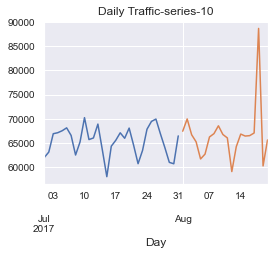

In [22]:
series = ["series-10", "series-19", "series-20", "series-40", "series-44"]

# subsetting train and test data 
# orginal DatetimeIndex: 782 entries, 2015-07-01 to 2017-08-20
n = 0
df_train = data.loc['2015-07-01':'2017-07-31', series[n]].copy(deep=True)
df_test = data.loc['2017-08-01':'2017-08-20', series[n]].copy(deep=True)

#Plotting data
df_train.loc['2017-07-01':'2017-08-20'].plot(figsize=(4,3), title= 'Daily Traffic-' + series[n], fontsize=10)
df_test.loc['2017-07-01':'2017-08-20'].plot(figsize=(4,3), title= 'Daily Traffic-' + series[n], fontsize=10)
plt.show()




### Same value

In [5]:
# simply take the last day value and estimate the same value for the next days
df_naive = df_test.copy().to_frame()
df_naive['naive'] = df_train[len(df_train) - 1]

plot_estimate(df_naive, 'Same value')
calculate_errors(df_test, df_naive['naive'])

NameError: name 'df_test' is not defined

### Same Value - all columns

Average SMAPE:  18.12183592960165
Bad validations: (array([ 6, 18, 19, 40, 44, 45], dtype=int64),)
Good validations: (array([], dtype=int64),)


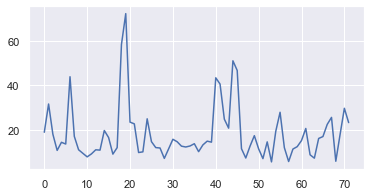

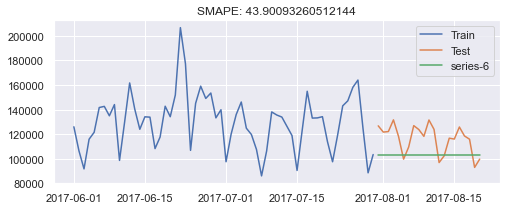

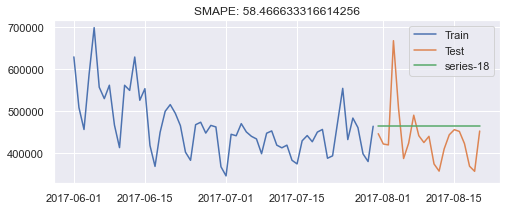

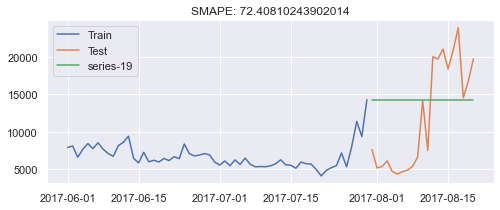

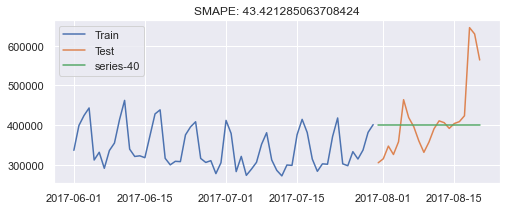

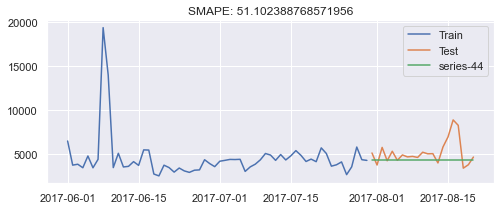

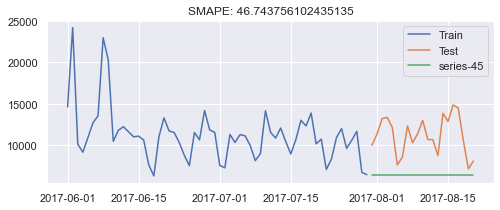

In [6]:
# copy the data frame and prepare the train/test/forcast frames
df_orig, df_train, df_test, df_test_predictions, df_kaggle_forecasts = prepare_data(remove_outliners=False)

# reset a few things
initialize_training()

# train all series and calculate 
for (colname, coldata) in df_train.iteritems():
    
    # naive extrapolation
    df_test_predictions[colname] = df_train[colname][len(df_train) - 1]

    # calculate the SMAPE error
    calculate_smape(df_test[colname], df_test_predictions[colname], print_result=False, label=colname + ' ')

# report training results
report_results(plot_smapes=True, plot_good_predictions=True, plot_bad_predictions=True)

#print(df_forecasts.head())


### Moving average

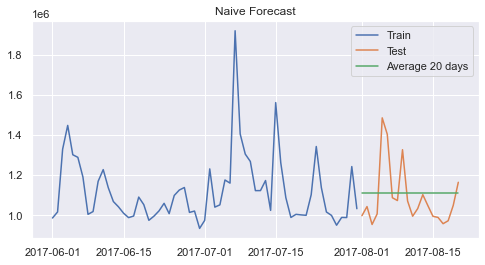

Bias: -22113.927273
MAE: 115914.636364
MSE: 21354095230.733475
RMSE: 146130.404881


In [32]:
# Moving average: take the average over the last 20 days
df_naive = df_test.copy().to_frame()
df_naive['naive'] = df_train.loc['2017-07-10':'2017-07-31'].mean()

plot_estimate(df_naive, 'Average 20 days')
calculate_errors(df_test, df_naive['naive'])

### Simple Exponential Smoothing

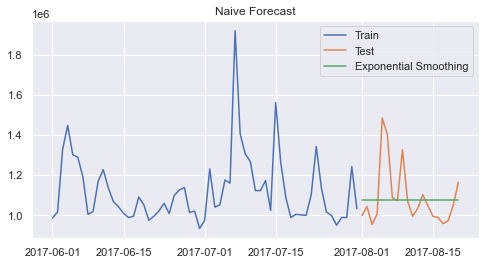

Bias: 11940.557060
MAE: 99294.697176
MSE: 21007646354.221897
RMSE: 144940.147489


In [35]:
# Simple Exponential Smoothing
df_naive = df_test.copy().to_frame()

fit2 = SimpleExpSmoothing(np.asarray(df_train)).fit(smoothing_level=0.6,optimized=False)
df_naive['naive'] = fit2.forecast(len(df_test))

plot_estimate(df_naive, 'Exponential Smoothing')
calculate_errors(df_test, df_naive['naive'])

### Holt’s Linear Trend method

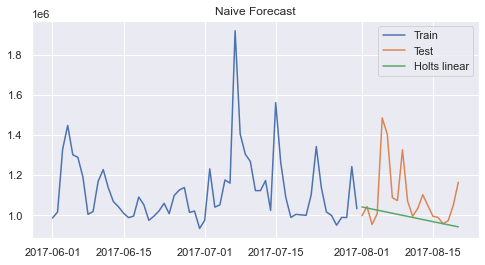

Bias: 95843.794881
MAE: 109758.989886
MSE: 29052469875.960072
RMSE: 170447.850899


In [38]:
df_naive = df_test.copy().to_frame()

fit = Holt(np.asarray(df_train)).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
df_naive['naive'] = fit.forecast(len(df_test))

plot_estimate(df_naive, 'Holts linear')
calculate_errors(df_test, df_naive['naive'])

### Holt-Winters Method

C:\Users\PhilippeHuet\venv\umdefi2\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


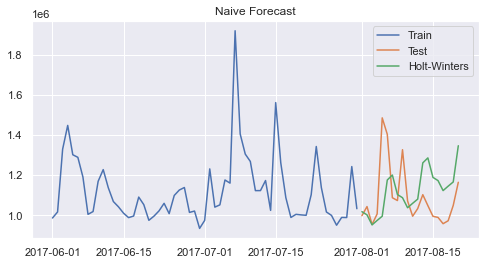

Bias: -30852.084699
MAE: 137310.980657
MSE: 31409287192.844116
RMSE: 177226.654860


In [40]:
df_naive = df_test.copy().to_frame()

fit = ExponentialSmoothing(np.asarray(df_train) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
df_naive['naive'] = fit.forecast(len(df_test))

plot_estimate(df_naive, 'Holt-Winters')
calculate_errors(df_test, df_naive['naive'])

## Univariate Time Series Forecasting

### Autoregression (AR)

Autoregression models an output (value at the next step) based on the linear combination of input variables (values at prior time steps)

The method is suitable for time series without trend and seasonal components.


In [7]:
# copy the data frame and prepare the train/test/forcast frames
df_orig, df_train, df_test, df_test_predictions, df_kaggle_forecasts = prepare_data(remove_outliners=True)

best lag: 28 7.294225662992789


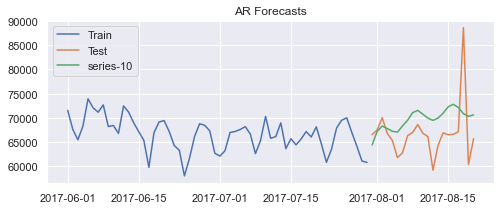

In [8]:
# single series 
colname = 'series-10'

# reset a few things
initialize_training()
dynamic=False

# fit model with different lags
bestlag = -1
bestsmape = 10000
for lag in range(1, 365):
    model_fit = AutoReg(df_train[colname], lags=lag).fit()
    df_test_predictions[colname] = model_fit.predict(start="2017-07-31", end="2017-08-20", dynamic=dynamic)

    smape = calculate_smape(df_test[colname], df_test_predictions[colname], store=False, print_result=False)
    if (smape < bestsmape):
        bestlag = lag
        bestsmape = smape

print('best lag:', bestlag, bestsmape)

# validate with the best lasg
model_fit = AutoReg(df_train[colname], lags=bestlag).fit()
df_test_predictions[colname] = model_fit.predict(start="2017-07-31", end="2017-08-20", dynamic=dynamic)
plot_estimate2(df_train, df_test, df_test_predictions, colname, title='AR Forecasts')


In [ ]:
# All columns
cols_to_model = df_train.columns
cols_to_plot=[]
#cols_to_model = ['series-10', 'series-20', 'series-30','series-47']
#cols_to_plot =  ['series-10', 'series-20', 'series-30','series-47']

initialize_training()

dynamic=False

def train_series_ar(colname):
    global smapes

    if colname not in cols_to_model:
        return

    # fit models with different lags and evaluate the best model
    bestlag = -1
    bestsmape = 10000
    for lag in range(1, 365):
        # train
        model_fit = AutoReg(df_train[colname], lags=lag).fit()
        # predict the test dataset
        df_test_predictions[colname] = model_fit.predict(start="2017-07-31", end="2017-08-20", dynamic=dynamic)
        # calculate the error
        smape = calculate_smape(df_test[colname], df_test_predictions[colname], store=False, print_result=False)
        # register the lag with the lowest error
        if (smape < bestsmape):
            bestlag = lag
            bestsmape = smape
    
    # select the best lag for this series 
    smapes = np.append(smapes, [bestsmape])
    print(colname + ' SMAPE: %f' % bestsmape)
    
    # recalculate the model over the full time range
    best_model_fit = AutoReg(df_orig[colname], lags=bestlag).fit()

    # make a forecast for the Kaggle competition
    df_kaggle_forecasts[colname] = best_model_fit.predict(start="2017-08-21", end="2017-09-10", dynamic=dynamic)

for (colname, coldata) in df_train.iteritems():
    train_series_ar(colname)

report_results(plot_smapes=True, plot_good_predictions=True, plot_bad_predictions=True)

kaggle_format_and_dump(df_kaggle_forecasts, "../output/working/ar_forecasts.csv")


### SARIMA

This method is an extension of the ARIMA model to deal with seasonal data. It models seasonal and non-seasonal components of the series separately.

There are four other seasonal parameters added to this approach in addition to three trend related parameters used in the ARIMA approach.

Non-seasonal parameters same as ARIMA

p: Autoregressive order

d: Differencing order

q: Moving average order


Seasonal parameters

P: Seasonal autoregressive order

D: Seasonal differencing order

Q: Seasonal moving average order

m: Number of time steps for a single seasonal period

The method is suitable for time series with trend and/or seasonal components.

In [43]:
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# create a set of sarima configs to try
def sarima_configs(seasonal=[0], test=False):
    if (test == True):
        return list([(1,0,1), (0,0,0,7), 'n'])

    models = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

# one-step sarima forecast
def sarima_forecast_one_step(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, 
        order=order,
        seasonal_order=sorder,
        trend=trend,
        enforce_stationarity=False,
        enforce_invertibility=False)
    # fit model 
    model_fit = model.fit(disp=False)
    # make 1 step forward prediction
    yhat = model_fit.predict(len(history), len(history))
    
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(colname, config, mode='validation'):
    # seed history with training dataset
    history = [x for x in df_train[colname]]
    
    # step over each time step in the test set
    for i in range(df_test.shape[0]):  
        # fit model and make 1-step forecast
        yhat = sarima_forecast_one_step(history, config)  
        # store forecast in list of predictions
        df_predictions[colname][i] = yhat  
        # add actual observation to history for next loop
        #history.append(df_test[colname][i])
        # Recursive Multi-step Forecast: the prior time step is used as an input for making a prediction on the following time step
        history.append(yhat)

    # estimate prediction error (if using test data)
    smape = 0
    if (mode == 'validation'):
        smape = calculate_smape(df_test[colname], df_predictions[colname], label=colname + ' ') 

    return smape

# score a model, return None on failure
def score_model(colname, cfg, mode='validation', debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(colname, cfg, mode)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(colname, cfg, mode)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search 
def grid_search(colname, cfg_list, mode='validation', parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(colname, cfg, mode) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(colname, cfg, mode) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

In [44]:
# copy the data frame and prepare the train/test/forcast frames
df_train, df_test, df_predictions = prepare_data(remove_outliners=True, mode='validation')


In [45]:
# single series 
colname = 'series-10'
mode = 'validation'

initialize_training()

# model configs
cfg_list = sarima_configs(test=True)

# grid search
scores = grid_search(colname, cfg_list, mode=mode)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

plot_estimate2(df_train, df_test, df_predictions, colname, title='SARIMAX Forecasts')

In [ ]:
# All columns
cols_to_model = df_train.columns
cols_to_plot= []
#cols_to_model = ['series-10', 'series-19', 'series-20', 'series-40', 'series-44']
#cols_to_plot =  ['series-10', 'series-19', 'series-20', 'series-40', 'series-44']

initialize_training()

dynamic=False

n= 0
def train_series_sarimax(colname):
    global smapes, n

    if colname not in cols_to_model:
        return

    sarima_forecast_series(cfg, colname)

    if colname in cols_to_plot:
        plot_estimate2(df_train, df_test, df_predictions, colname, title='SMAPE: ' + str(smapes[n]))

    # recalculate the model over the full time range
    #model_fit = SARIMAX(df_orig[colname], order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()

    # make a forecast for the Kaggle competition
    #df_kaggle_forecasts[colname] = model_fit.predict(start="2017-08-21", end="2017-09-10", dynamic=dynamic)

    n += 1

for (colname, coldata) in df_train.iteritems():
    train_series_sarimax(colname)

report_results(plot_smapes=True, plot_good_predictions=True, plot_bad_predictions=True)

#kaggle_format_and_dump(df_kaggle_forecasts, "../output/working/sarimax_forecasts.csv")

### AUTO.ARIMA

In [56]:
# copy the data frame and prepare the train/test/forcast frames
df_orig, df_train, df_test, df_test_predictions, df_kaggle_forecasts = prepare_data(remove_outliners=True, use_short_past=True)

In [ ]:
# single series
# https://medium.com/analytics-vidhya/time-series-forecasting-sarima-vs-auto-arima-models-f95e76d71d8f 
#colname = 'series-10' # good
colname = 'series-20' # bad

# reset a few things
initialize_training()
dynamic = False

#model = auto_arima(df_orig[colname])
model = auto_arima(df_orig[colname],
                start_p=1, start_q=1,
                test='adf', # used adftest to find optimal 'd'
                max_p=5, max_q=5,
                m=1,        # frequency of series
                d=0,       
                seasonal=True,
                start_P=0, start_Q=0,
                D=1, 
                trace=False,
                error_action='ignore',  
                suppress_warnings=True, 
                stepwise=True,
                with_intercept=False)
print(model.summary())
model.plot_diagnostics(figsize=(8,8))
plt.show()

model_fit = model.fit(df_orig[colname])

df_test_predictions[colname] = model_fit.predict(n_periods=len(df_test))

smape = calculate_smape(df_test[colname], df_test_predictions[colname], label=colname + ' ')

plot_estimate2(df_train, df_test, df_test_predictions, colname, title='SARIMAX Forecasts')

In [ ]:
# All columns
cols_to_model = df_train.columns
cols_to_plot=[]
cols_to_model = ['series-10', 'series-19', 'series-20', 'series-40', 'series-44']
cols_to_plot =  ['series-10', 'series-19', 'series-20', 'series-40', 'series-44']

initialize_training()

n = 0
def train_series_auto_arima(colname):
    global smapes, n

    if colname not in cols_to_model:
        return

    # test stationarity
    test_stationarity(df_orig[colname], label=colname +' ' )

    # train
    model = auto_arima(df_orig[colname], 
                start_p=1, start_q=1,
                max_p=3, max_q=3, m=12,
                start_P=0, seasonal=True,
                d=1, D=1, trace=False,
                error_action='ignore',  
                suppress_warnings=True, 
                stepwise=True)

    model.fit(df_train[colname])

    # predict the test dataset
    df_test_predictions[colname] = model.predict(n_periods=len(df_test))
    # calculate the error
    smape = calculate_smape(df_test[colname], df_test_predictions[colname], label=colname + ' ')
    
    # recalculate the model over the full time range
    model = auto_arima(df_orig[colname])

    # make a forecast for the Kaggle competition
    df_kaggle_forecasts[colname] = model.predict(n_periods=len(df_kaggle_forecasts))

    if colname in cols_to_plot:
        plot_estimate2(df_train, df_test, df_test_predictions, colname, title='SMAPE: ' + str(smapes[n]))

    n += 1

for (colname, coldata) in df_train.iteritems():
    train_series_auto_arima(colname)

report_results(plot_smapes=True, plot_good_predictions=True, plot_bad_predictions=True)

kaggle_format_and_dump(df_kaggle_forecasts, "../output/working/auto_arimaforecasts.csv")